In [54]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sns
from   sklearn.metrics.pairwise import cosine_similarity

## colaborative filtering with Pearson Correlation

In [55]:
class PreProcess:
    def read_data(self,file_path):
        return pd.read_csv(file_path)
    def null_check(self,df):
        print(df.isnull().sum())
    def remove_null_data(self,df):
        return df.dropna()
    def peek_data_head(self,df,number):
        return df.head(number)
    def peek_data_last(self,df,number):
        return df.tail(number)
    def join_datasets(self,df1,df2,foreign_key,where='left'):
        return df1.merge(df2,how=where,on=foreign_key)
    def user_name_edit(self,df):
        df['userId'] = df['userId'].apply(lambda x : 'USR-'+str(int(x)) )
        return df
        
    
class NonPersonalizedRecom:
    def __init__(self,data):
        self.df = data
        
    def recommend(self,groupby_properites,aggprop):
        ## sort the values based on their rating count
        non_personalized_rating = self.df.groupby(groupby_properites)[[aggprop]].sum().sort_values(by=aggprop,ascending=False) 
        return non_personalized_rating
    
class viz:
    def viz_bar(self,data):
        data.plot(kind='barh')
        
    def viz_pie(self,data,target,labels,ex):
        plt.pie(data.reset_index()[target],labels=labels,autopct='%.0f%%', shadow=True,explode=tuple([ex for x in range(len(labels))]))

class interaction_matrix:
    def __init__(self,df,row,columns,interaction_value):
        self.df      = df
        self.row     = row
        self.columns = columns
        self.interaction_value = interaction_value
    def calculate(self):
        return self.df.pivot_table(index=self.row,columns = [self.columns],values=self.interaction_value,fill_value = 0.0)
        
        
class UserBased_Pearson_coeff:
    def __init__(self,target_user_id,interaction_matrix):
        self.target_user_id = target_user_id
        self.interaction_matrix = interaction_matrix
        
        
    def similer_users(self):
        ## using the user Id find the user_row (which is called active_user) 
        ## then find the pearson correlation with the other row of the interaction matrix
        ## axis = 1 means row wise calulation
        active_user = self.interaction_matrix.loc[self.target_user_id]
        similar_users = self.interaction_matrix.corrwith(active_user,axis=1,method='pearson')
        return similar_users
        

class UserBased_Cosine_sim:
    ## cosine similarity relation
    ## doing same as pearson coeff
    ## use the coeff to find the user vector relationship
    ## in cosine similarity first we find relation matrix
    ## means every user relation on every user
    ## after the matrix produced we select out target user
    
    def __init__(self,im_matrix):
        self.im_matrix = im_matrix
        
    def cosine_sm(self):
        relation_matrix = cosine_similarity(self.im_matrix)
        ## the relation matrix will be user to user
        ## cosine_similarity will find row to row relationship
        ## if the user in the row then it will find user user reation
        ## if the product is in the row then it will find product- product relationship
        col = self.im_matrix.index.values ## this will find all the row / user id
        relation_mat_df = pd.DataFrame(relation_matrix,columns=col,index=col)
        return relation_mat_df
    
    def find_similar_user(self,picked_user_id,relation_mat_df):
        #active_user = self.im_matrix.loc[picked_user_id]
        similar_users = relation_mat_df.loc[picked_user_id]
        return similar_users
    
    def top_10_similar_users(self,similar_users):
        pass
        

class ItemBAsed_Pearson_coeff:
    ## in this case instead of users we select a product
    ## and run pearson coeff column wise to find 
    ## similarity with product to product
    
    def __init__(self,product_name,im_matrix):
        self.product_name = product_name
        self.im_matrix = im_matrix
        
    def simillar_movies(self):
        ## find the column
        target_column = self.im_matrix[self.product_name]
        recom = self.im_matrix.corrwith(target_column)
        return recom
        
class ItemBased_Cosine_sim:
    # if the movie name is in row in the interaction matrix then ok
    # if not then transpose it
    # im_matrix.T is to transpose a matrx .
    # because we need movie on the row side
    # before finding cosine similarity
    # up until now we have users in the row
    # need to change that
    
    def __init__(self,df):
        self.df = df
        
    def create_interaction_matrix_for_item_based(self):
        im = self.df.pivot_table(index='title',columns=['userId'],values='rating',fill_value=0.0)
        cosine_sim = cosine_similarity(im)
        ## it will create an item vs item similarity matrix
        ## both row and column will be same 
        cosine_sim_df = pd.DataFrame(cosine_sim,columns=im.index.values,index = im.index.values)
        return cosine_sim_df
    
    def final_recomemd(self,target_item_name,cosine_sim_df):
        similar_movie = cosine_sim_df[target_item_name]
        return similar_movie.sort_values(ascending=False)[1:6]
        



class RecomendActualProduct:
    # im_matrix is interaction matrix
    def __init__(self,active_user_id,similar_users_ids,im_matrix):
        
        ## setting up active user Id
        ## then list of simillar users
        self.active_user_id    = active_user_id
        self.similar_users_ids = similar_users_ids
        self.im_matrix         = im_matrix
        
    def recom_product(self):   
        ## find the actual row
        active_user_row_info = self.im_matrix.loc[self.active_user_id]
        
        ## setting up a empty list it will contain the other users
        ## watched movie
        ## it can have duplicate because its the top 10 simillar  users watched movie
        item_recommended = []
        
        ## loop through the similar usrers ids
        for sm_user_id in self.similar_users_ids:
            # find the actual row of the users
            similar_user_row_info = self.im_matrix.loc[sm_user_id]
            ## loop through the target user movie title and rating
            for title,rating in similar_user_row_info.items():
                # if rating more than 0
                ## or we can say that rating is greater then 3 or 4 depending 
                ## how you want to filter it
                ## remember 0 means he did not see the movie
                ## more than 3 means movie not only seen but also has rating more than 3
                if rating > 3:
                    ## and the the active user does not see the movie
                    if active_user_row_info[title] == 0:
                        # create the data
                        recom_item = {'Movie':title,'Rating':rating}
                        
                        ## append it to the list
                        item_recommended.append(recom_item)
        return item_recommended
        
        
        
 
        
        
        
        
    
    

In [56]:
r = PreProcess()
movies_df  = r.read_data("../input/mymoviedatasetsforrecom/movies.csv")
ratings_df = r.read_data("../input/mymoviedatasetsforrecom/ratings.csv")



In [57]:
r.peek_data_head(movies_df,10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [58]:
r.peek_data_head(ratings_df,10)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
5,1,70,3.0,964982400
6,1,101,5.0,964980868
7,1,110,4.0,964982176
8,1,151,5.0,964984041
9,1,157,5.0,964984100


In [59]:
print(r.null_check(movies_df))
print(r.null_check(ratings_df))

movieId    0
title      0
genres     0
dtype: int64
None
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
None


In [60]:
## merging data based on  movieId foreign key
df = r.join_datasets(movies_df,ratings_df,'movieId')


In [61]:
r.null_check(df)

movieId       0
title         0
genres        0
userId       18
rating       18
timestamp    18
dtype: int64


In [62]:
## remove_null
df = r.remove_null_data(df)
df.head(10)

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0,9.649827e+08
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0,8.474350e+08
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7.0,4.5,1.106636e+09
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15.0,2.5,1.510578e+09
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17.0,4.5,1.305696e+09
5,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,18.0,3.5,1.455210e+09
6,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,19.0,4.0,9.657056e+08
7,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,21.0,3.5,1.407619e+09
8,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,27.0,3.0,9.626853e+08
9,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,31.0,5.0,8.504666e+08


In [63]:
r.user_name_edit(df)

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,USR-1,4.0,9.649827e+08
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,USR-5,4.0,8.474350e+08
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,USR-7,4.5,1.106636e+09
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,USR-15,2.5,1.510578e+09
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,USR-17,4.5,1.305696e+09
...,...,...,...,...,...,...
100849,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,USR-184,4.0,1.537109e+09
100850,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,USR-184,3.5,1.537110e+09
100851,193585,Flint (2017),Drama,USR-184,3.5,1.537110e+09
100852,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,USR-184,3.5,1.537110e+09


In [64]:
non_personalized_recom = NonPersonalizedRecom(df)
non_recom = non_personalized_recom.recommend('title','rating')

In [65]:
non_recom

,rating
title,
"Shawshank Redemption, The (1994)",1404.0
Forrest Gump (1994),1370.0
Pulp Fiction (1994),1288.5
"Matrix, The (1999)",1165.5
"Silence of the Lambs, The (1991)",1161.0
...,...
Uncle Nino (2003),0.5
Legionnaire (1998),0.5
Ring of Terror (1962),0.5


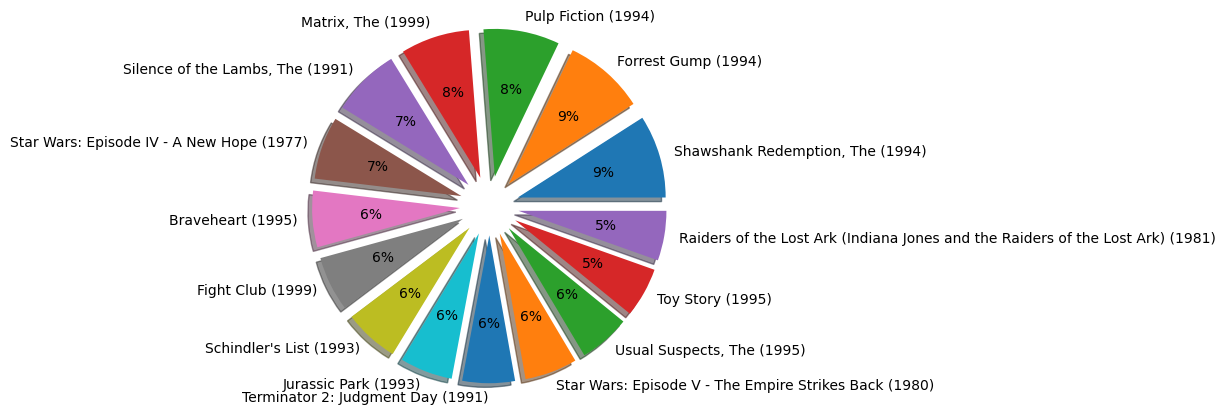

In [66]:
v = viz()
v.viz_pie(non_recom.head(15),'rating',non_recom.head(15).reset_index()['title'],.2)

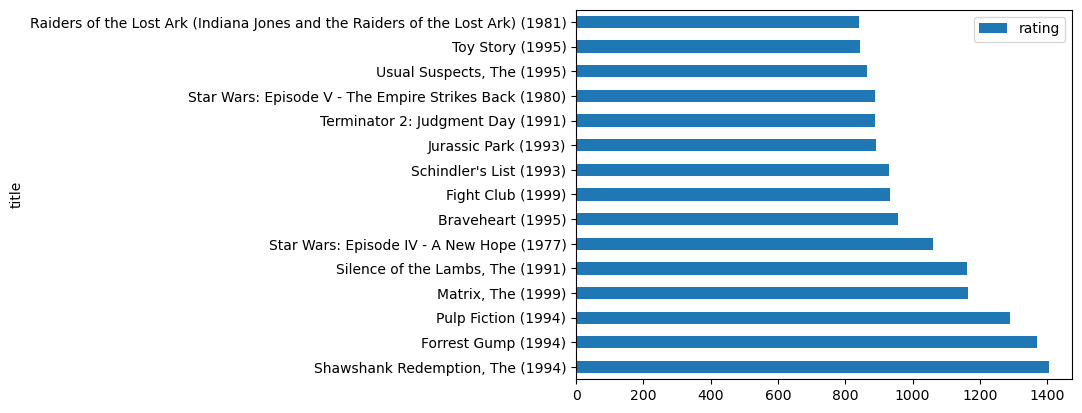

In [67]:
v.viz_bar(non_recom.head(15))

In [68]:
im = interaction_matrix(df,row='userId',columns='title',interaction_value='rating')
im_matrix = im.calculate()


In [69]:
im_matrix

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
USR-1,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,4.0,0
USR-10,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0
USR-100,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0
USR-101,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,4.0,0.0,0.0,0.0,0
USR-102,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
USR-95,0,0,0.0,0,0,0.0,3.0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,2.5,3.0,0.0,0.0,0
USR-96,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0
USR-97,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0


In [70]:
## user based collaborative filtering with pearson coeff
active_user_id = 'USR-1'
recom = UserBased_Pearson_coeff(active_user_id,im_matrix)
similar_users = recom.similer_users().sort_values(ascending=False)[1:10]

In [71]:
similer_users_ids = similar_users.index.values

In [72]:
similer_users_ids 

array(['USR-266', 'USR-313', 'USR-368', 'USR-57', 'USR-39', 'USR-452',
       'USR-91', 'USR-469', 'USR-45'], dtype=object)

In [73]:
recom_prod = RecomendActualProduct(active_user_id,similer_users_ids,im_matrix)

In [74]:
top_10_similar_users_watched_movies = recom_prod.recom_product()

In [75]:
## group by similar movie and how much it is watched
## then we recommnd based on the count 
top_10_similar_users_watched_movies_df = pd.DataFrame(top_10_similar_users_watched_movies)
top_10_similar_users_watched_movies_df

,Movie,Rating
0,2001: A Space Odyssey (1968),5.0
1,Aliens (1986),5.0
2,Analyze This (1999),4.0
3,Austin Powers: The Spy Who Shagged Me (1999),5.0
4,Blade (1998),4.0
...,...,...
1193,"Whole Nine Yards, The (2000)",4.0
1194,William Shakespeare's Romeo + Juliet (1996),5.0
1195,"World Is Not Enough, The (1999)",4.0
1196,"X-Files: Fight the Future, The (1998)",4.0


In [76]:
final_recom = top_10_similar_users_watched_movies_df.groupby('Movie')[['Rating']].sum().sort_values(by='Rating',ascending=False).head(10)

In [77]:
final_recom.columns = ['Total Rating']


In [78]:
final_recom

,Total Rating
Movie,
"Godfather, The (1972)",39.0
Aliens (1986),38.0
"Sixth Sense, The (1999)",37.0
"Godfather: Part II, The (1974)",36.0
Terminator 2: Judgment Day (1991),35.0
Die Hard (1988),32.0
"Hunt for Red October, The (1990)",30.5
Blade Runner (1982),30.0
Gattaca (1997),27.5


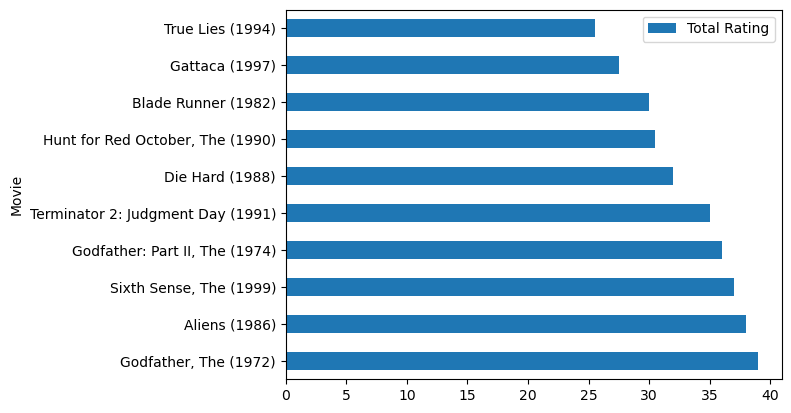

In [79]:
v.viz_bar(final_recom)

# User Based Cosine Similarity

In [80]:
user_co_sim = UserBased_Cosine_sim(im_matrix)

In [81]:
sim_df = user_co_sim.cosine_sm()

In [82]:
sim_df

,USR-1,USR-10,USR-100,USR-101,USR-102,USR-103,USR-104,USR-105,USR-106,USR-107,...,USR-90,USR-91,USR-92,USR-93,USR-94,USR-95,USR-96,USR-97,USR-98,USR-99
USR-1,1.000000,0.016875,0.147763,0.141447,0.156466,0.211480,0.121173,0.090142,0.019425,0.066894,...,0.051841,0.334727,0.028767,0.232766,0.110082,0.178069,0.282780,0.086557,0.062187,0.066231
USR-10,0.016875,1.000000,0.090474,0.020533,0.036215,0.116766,0.178308,0.149245,0.133146,0.003137,...,0.000000,0.055251,0.016773,0.029036,0.038062,0.042865,0.018888,0.057771,0.130223,0.020587
USR-100,0.147763,0.090474,1.000000,0.070894,0.142033,0.136122,0.178267,0.065328,0.000000,0.098179,...,0.015134,0.189074,0.000000,0.122328,0.124926,0.093664,0.071043,0.078111,0.053039,0.079063
USR-101,0.141447,0.020533,0.070894,1.000000,0.026755,0.105728,0.045393,0.065297,0.000000,0.000000,...,0.000000,0.133919,0.000000,0.012955,0.000000,0.070774,0.107449,0.103712,0.000000,0.000000
USR-102,0.156466,0.036215,0.142033,0.026755,1.000000,0.094133,0.087527,0.051458,0.029935,0.353838,...,0.000000,0.259438,0.000000,0.219928,0.586507,0.046217,0.136751,0.048376,0.054637,0.428520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
USR-95,0.178069,0.042865,0.093664,0.070774,0.046217,0.184223,0.125659,0.142743,0.044271,0.000000,...,0.061351,0.265121,0.023369,0.091787,0.054546,1.000000,0.208704,0.089793,0.054944,0.023075
USR-96,0.282780,0.018888,0.071043,0.107449,0.136751,0.177743,0.087595,0.083746,0.021467,0.130466,...,0.044602,0.271696,0.000000,0.240489,0.204494,0.208704,1.000000,0.144190,0.057705,0.072585
USR-97,0.086557,0.057771,0.078111,0.103712,0.048376,0.102086,0.048995,0.141125,0.075348,0.000000,...,0.000000,0.150644,0.000000,0.045750,0.044044,0.089793,0.144190,1.000000,0.080515,0.000000
USR-98,0.062187,0.130223,0.053039,0.000000,0.054637,0.143027,0.129430,0.163750,0.060405,0.019877,...,0.028132,0.131384,0.000000,0.048703,0.043413,0.054944,0.057705,0.080515,1.000000,0.000000


In [83]:
active_user_id = 'USR-1'
similar_users = user_co_sim.find_similar_user(active_user_id,sim_df)

In [84]:
top_similar_users = similar_users.sort_values(ascending=False)[1:10]

In [85]:
similer_users_ids = top_similar_users.index.values

In [86]:
similer_users_ids

array(['USR-266', 'USR-313', 'USR-368', 'USR-57', 'USR-91', 'USR-469',
       'USR-39', 'USR-288', 'USR-452'], dtype=object)

In [87]:
rp = RecomendActualProduct(active_user_id,similer_users_ids,im_matrix)

In [88]:
top_10_similar_users_watched_movies = rp.recom_product()
top_10_similar_users_watched_movies_df = pd.DataFrame(top_10_similar_users_watched_movies)
top_10_similar_users_watched_movies_df

,Movie,Rating
0,2001: A Space Odyssey (1968),5.0
1,Aliens (1986),5.0
2,Analyze This (1999),4.0
3,Austin Powers: The Spy Who Shagged Me (1999),5.0
4,Blade (1998),4.0
...,...,...
1346,What's Eating Gilbert Grape (1993),5.0
1347,"Whole Nine Yards, The (2000)",5.0
1348,"World Is Not Enough, The (1999)",5.0
1349,"X-Files: Fight the Future, The (1998)",5.0


In [89]:
final_recom = top_10_similar_users_watched_movies_df.groupby('Movie')[['Rating']].sum().sort_values(by='Rating',ascending=False).head(10)

In [90]:
final_recom.columns = ['Total Rating']
final_recom

,Total Rating
Movie,
Aliens (1986),38.0
Terminator 2: Judgment Day (1991),34.0
"Godfather, The (1972)",34.0
Blade Runner (1982),34.0
Die Hard (1988),32.0
"Godfather: Part II, The (1974)",32.0
"Sixth Sense, The (1999)",32.0
Jaws (1975),30.0
Raising Arizona (1987),28.0


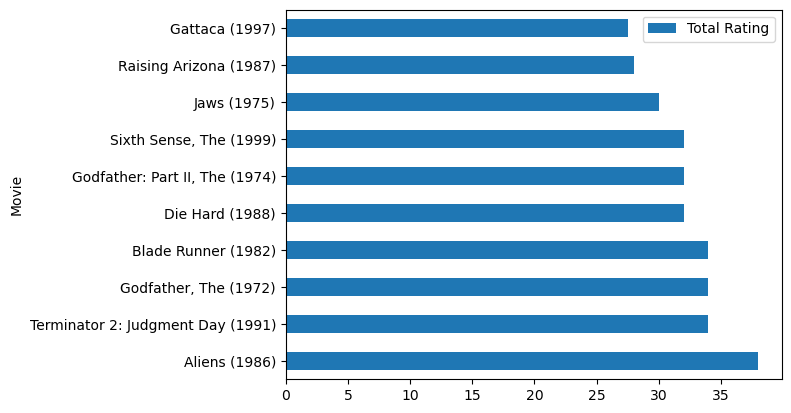

In [91]:
v.viz_bar(final_recom)

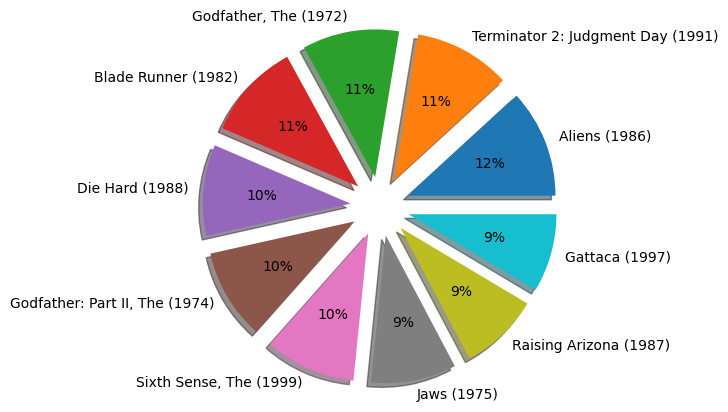

In [92]:
v.viz_pie(final_recom,'Total Rating',final_recom.reset_index()['Movie'],.2)

In [93]:
picked_product_name = 'Godfather, The (1972)'
itpc = ItemBAsed_Pearson_coeff(picked_product_name,im_matrix)
recom = itpc.simillar_movies().sort_values(ascending=False)[1:10]

In [94]:
recom 

title
Godfather: Part II, The (1974)            0.769390
Goodfellas (1990)                         0.560246
One Flew Over the Cuckoo's Nest (1975)    0.496048
Reservoir Dogs (1992)                     0.442128
Fargo (1996)                              0.418042
Apocalypse Now (1979)                     0.414011
Scarface (1983)                           0.407608
Casablanca (1942)                         0.397500
Alien (1979)                              0.396419
dtype: float64

In [95]:
final_recom_product = pd.DataFrame(recom,columns=['correlation'])

In [96]:
final_recom_product

,correlation
title,
"Godfather: Part II, The (1974)",0.769390
Goodfellas (1990),0.560246
One Flew Over the Cuckoo's Nest (1975),0.496048
Reservoir Dogs (1992),0.442128
Fargo (1996),0.418042
Apocalypse Now (1979),0.414011
Scarface (1983),0.407608
Casablanca (1942),0.397500
Alien (1979),0.396419


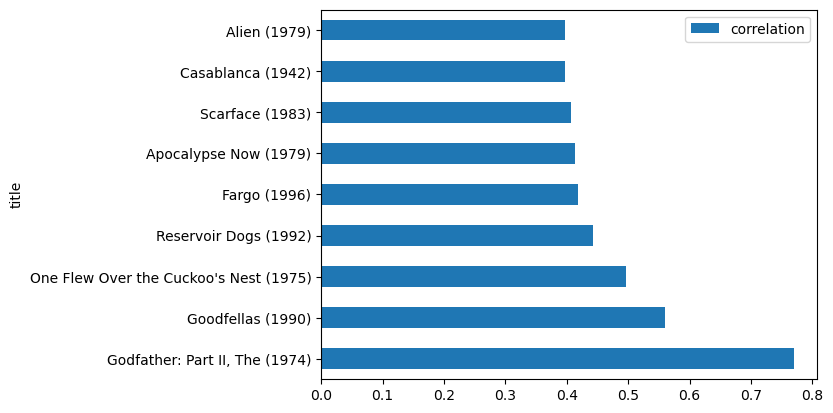

In [97]:
v.viz_bar(final_recom_product)

In [98]:
im_matrix

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
USR-1,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,4.0,0
USR-10,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0
USR-100,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0
USR-101,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,4.0,0.0,0.0,0.0,0
USR-102,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
USR-95,0,0,0.0,0,0,0.0,3.0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,2.5,3.0,0.0,0.0,0
USR-96,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0
USR-97,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0


In [99]:
ics = ItemBased_Cosine_sim(df)
interaction_cosine_similarity_mat = ics.create_interaction_matrix_for_item_based()

In [100]:
interaction_cosine_similarity_mat

,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
'71 (2014),1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.141653,0.000000,...,0.000000,0.342055,0.543305,0.707107,0.0,0.000000,0.139431,0.327327,0.000000,0.0
'Hellboy': The Seeds of Creation (2004),0.000000,1.000000,0.707107,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
'Round Midnight (1986),0.000000,0.707107,1.000000,0.000000,0.000000,0.0,0.176777,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
'Salem's Lot (2004),0.000000,0.000000,0.000000,1.000000,0.857493,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
'Til There Was You (1997),0.000000,0.000000,0.000000,0.857493,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eXistenZ (1999),0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.211467,0.216295,0.097935,0.132489,...,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.192259,0.000000,0.170341,0.0
xXx (2002),0.139431,0.000000,0.000000,0.000000,0.000000,0.0,0.089634,0.000000,0.276512,0.019862,...,0.069716,0.305535,0.173151,0.246482,0.0,0.192259,1.000000,0.270034,0.100396,0.0
xXx: State of the Union (2005),0.327327,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.156764,0.000000,...,0.000000,0.382543,0.177838,0.231455,0.0,0.000000,0.270034,1.000000,0.000000,0.0
¡Three Amigos! (1986),0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.372876,0.180009,0.169385,0.249586,...,0.180009,0.000000,0.000000,0.000000,0.0,0.170341,0.100396,0.000000,1.000000,0.0


In [101]:
picked_product_name = 'Godfather, The (1972)'
final_recommend = ics.final_recomemd(picked_product_name,interaction_cosine_similarity_mat)

In [102]:
final_recommend 

Godfather: Part II, The (1974)               0.821773
Goodfellas (1990)                            0.664841
One Flew Over the Cuckoo's Nest (1975)       0.620536
Star Wars: Episode IV - A New Hope (1977)    0.595317
Fargo (1996)                                 0.588614
Name: Godfather, The (1972), dtype: float64

In [103]:
final_recom_df = pd.DataFrame(final_recommend)

In [104]:
final_recom_df.columns = ['Correlation']

In [105]:
final_recom_df

,Correlation
"Godfather: Part II, The (1974)",0.821773
Goodfellas (1990),0.664841
One Flew Over the Cuckoo's Nest (1975),0.620536
Star Wars: Episode IV - A New Hope (1977),0.595317
Fargo (1996),0.588614


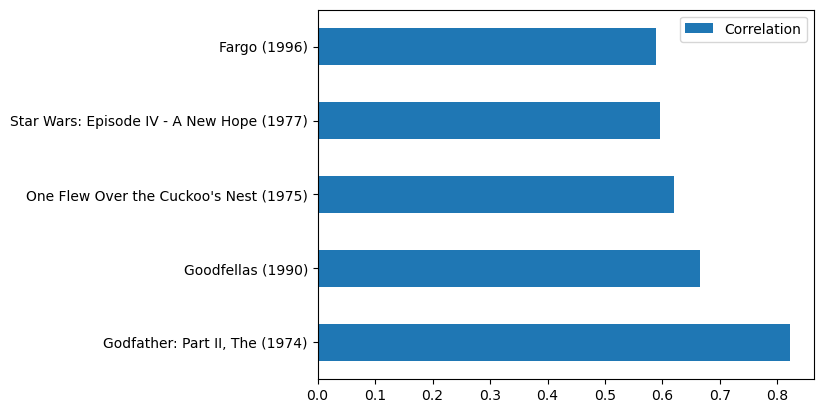

In [106]:
v.viz_bar(final_recom_df)